In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import datetime

In [158]:
TSLA = yf.Ticker('TSLA')
df = TSLA.history(start = "2001-01-02")

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Drop Unecessary Columns
df = df.drop(['dividends','stock_splits'],axis=1)

# Change the original index column to a date column, add a new index column
df = df.reset_index().rename(columns={'Date': 'date'})

# Convert Date column to datetime
df.loc[:, 'date'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.tz_localize(None)

df['date'].dt.date

# Get month of each sample
df['month'] = df['date'].dt.month

df

,date,open,high,low,close,volume,month
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,281494500,6
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,257806500,6
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000,7
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000,7
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,103003500,7
...,...,...,...,...,...,...,...
3221,2023-04-17,186.320007,189.690002,182.690002,187.039993,116662200,4
3222,2023-04-18,187.149994,187.690002,183.580002,184.309998,92067000,4
3223,2023-04-19,179.100006,183.500000,177.649994,180.589996,125732700,4
3224,2023-04-20,166.169998,169.699997,160.559998,162.990005,210970800,4


Data Exploration

In [159]:
# Summary Statistics
df.describe()

,date,open,high,low,close,volume,month
count,3226,3226.000000,3226.000000,3226.000000,3226.000000,3.226000e+03,3226.000000
mean,2016-11-23 04:01:29.274643456,61.604141,62.995135,60.079253,61.568494,9.532011e+07,6.563546
min,2010-06-29 00:00:00,1.076000,1.108667,0.998667,1.053333,1.777500e+06,1.000000
25%,2013-09-11 06:00:00,9.458833,9.670667,9.244833,9.469167,4.346588e+07,4.000000
50%,2016-11-21 12:00:00,16.479334,16.710667,16.251333,16.483666,7.734000e+07,7.000000
75%,2020-02-06 18:00:00,35.341832,36.419833,33.941501,35.155666,1.210789e+08,10.000000
max,2023-04-21 00:00:00,411.470001,414.496674,405.666656,409.970001,9.140820e+08,12.000000
std,NaN,96.265747,98.485080,93.773368,96.154390,8.171735e+07,3.446939


Text(0.5, 1.0, 'Tesla Stock Price 2010-06-29 - 2023-04-21')

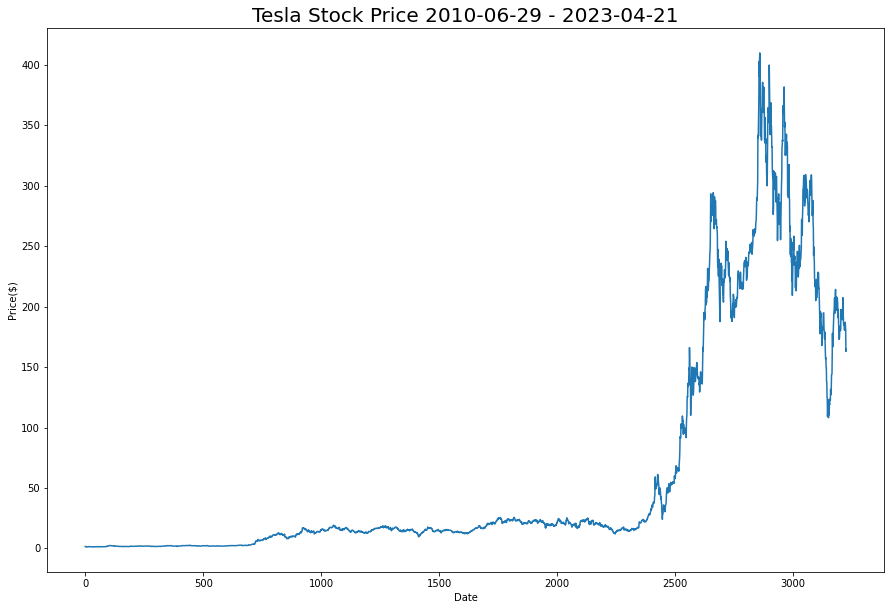

In [160]:
# Close Price Movement
plt.figure(figsize =(15,10))
plt.plot(df['close'])
plt.xlabel('Date')
plt.ylabel('Price($)')
plt.title(f'Tesla Stock Price 2010-06-29 - {datetime.date.today()}', fontsize =20)

Text(0.5, 1.0, 'Tesla Daily Return (%)  2010-06-29 - 2023-04-21')

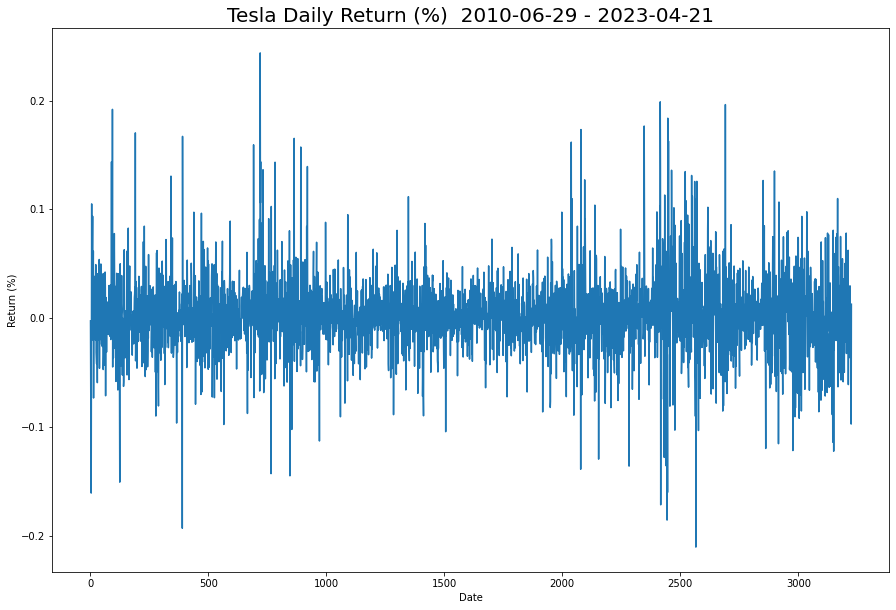

In [161]:
# Daily Return
new_df = pd.DataFrame()
new_df['return'] = ((df['close']-df['close'].shift(1))/df['close'].shift(1))
plt.figure(figsize =(15,10))
plt.plot(new_df['return'])
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.title(f'Tesla Daily Return (%)  2010-06-29 - {datetime.date.today()}', fontsize =20)

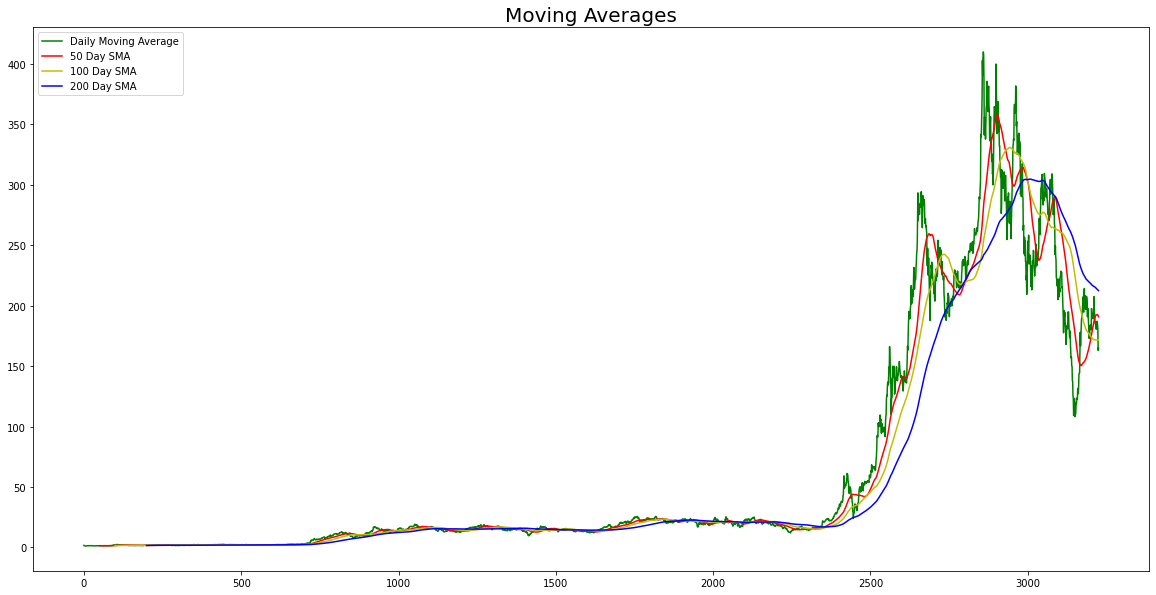

In [162]:
# Simply Moving Average

SMA = pd.DataFrame()

SMA['Daily'] = df['close']
SMA['50 Day SMA'] = df['close'].rolling(window = 50).mean()
SMA['100 Day SMA'] = df['close'].rolling(window = 100).mean()
SMA['200 Day SMA'] = df['close'].rolling(window = 200).mean()

plt.figure(figsize=(20,10))
plt.plot(SMA['Daily'],'g-', label ='Daily Moving Average')
plt.plot(SMA['50 Day SMA'],'r-', label = '50 Day SMA')
plt.plot(SMA['100 Day SMA'], 'y-', label = '100 Day SMA')
plt.plot(SMA['200 Day SMA'], 'b-', label = '200 Day SMA')

plt.title("Moving Averages", fontsize = 20)
plt.legend()



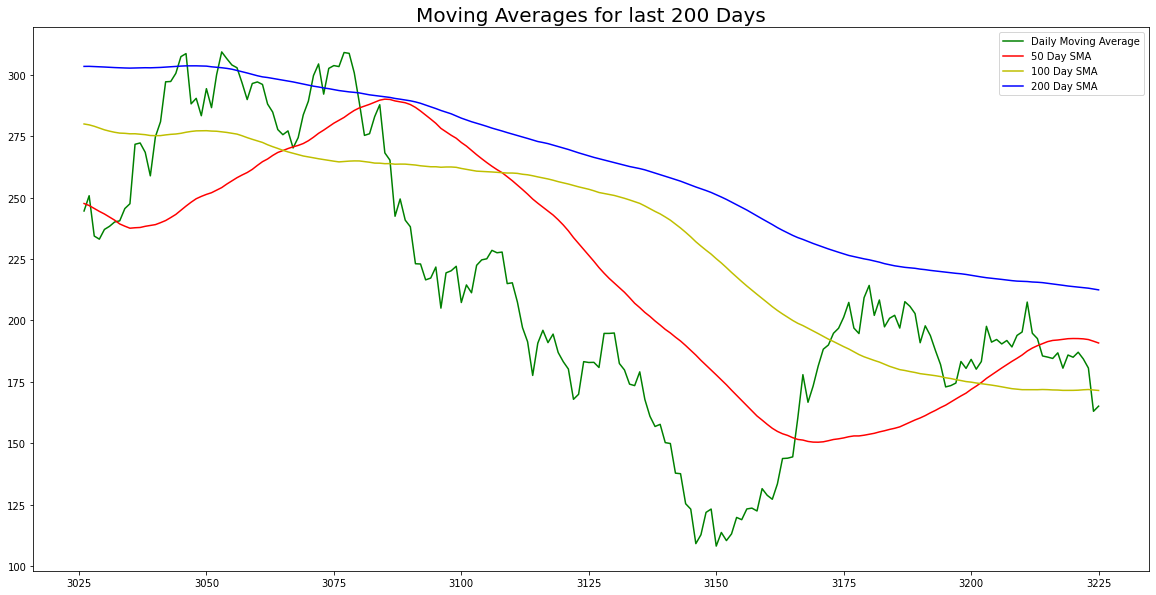

In [163]:
# SMA of Last 200 Trading Days

plt.figure(figsize=(20,10))
plt.plot(SMA['Daily'].iloc[-200:],'g-', label ='Daily Moving Average')
plt.plot(SMA['50 Day SMA'].iloc[-200:],'r-', label = '50 Day SMA')
plt.plot(SMA['100 Day SMA'].iloc[-200:], 'y-', label = '100 Day SMA')
plt.plot(SMA['200 Day SMA'].iloc[-200:], 'b-', label = '200 Day SMA')

plt.title("Moving Averages for last 200 Days", fontsize = 20)
plt.legend()

Preparing the Data

Train, Test, Validate

In [164]:
# Splitting the Data into Train, Test, and Validate Sets
    # Note that stock price data is temporal, as such we want to split our data such that it is ordered as training, testing and validation, respectively. 
    # This is because the past stock price helps predict the following stock price


# Will split the data as following: Train (60%) , Test(20%), Validate (20%)

features = df.drop(['close'],axis=1)
target = df['close']

train_split = int(0.6 * len(df))
val_split = int(0.8 * len(df))

In [174]:
# Training Set
X_train = features.iloc[:train_split, :]
y_train = target.iloc[:train_split]
X_train['date'] = X_train['date'].apply(lambda x: datetime.datetime.timestamp(x))

# Check size
X_train.shape
X_train

/var/folders/qh/cz1489t14qz61cb2gvxy3gx40000gn/T/ipykernel_10199/2416368087.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['date'] = X_train['date'].apply(lambda x: datetime.datetime.timestamp(x))


,date,open,high,low,volume,month
0,1.277784e+09,1.266667,1.666667,1.169333,281494500,6
1,1.277870e+09,1.719333,2.028000,1.553333,257806500,6
2,1.277957e+09,1.666667,1.728000,1.351333,123282000,7
3,1.278043e+09,1.533333,1.540000,1.247333,77097000,7
4,1.278389e+09,1.333333,1.333333,1.055333,103003500,7
...,...,...,...,...,...,...
1930,1.519794e+09,23.504667,23.682667,22.814667,91045500,2
1931,1.519880e+09,23.000668,23.244667,22.004667,103284000,3
1932,1.519967e+09,21.798668,22.348000,21.531334,76392000,3
1933,1.520226e+09,22.159332,22.516666,21.952667,57357000,3


In [175]:
# Testing Set
X_test = features.iloc[train_split:val_split, :]
y_test = target.iloc[train_split:val_split]
X_test['date'] = X_test['date'].apply(lambda x: datetime.datetime.timestamp(x))


# Check size
X_test.shape
X_test

/var/folders/qh/cz1489t14qz61cb2gvxy3gx40000gn/T/ipykernel_10199/2997720029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['date'] = X_test['date'].apply(lambda x: datetime.datetime.timestamp(x))


,date,open,high,low,volume,month
1935,1.520399e+09,21.695999,22.166668,21.449333,75109500,3
1936,1.520485e+09,22.190666,22.219999,21.751333,53493000,3
1937,1.520572e+09,21.606667,21.899332,21.491333,82602000,3
1938,1.520827e+09,21.907333,23.147333,21.766666,123960000,3
1939,1.520914e+09,21.907333,23.147333,21.766666,89487000,3
...,...,...,...,...,...,...
2575,1.600661e+09,151.043335,151.893326,135.690002,328430400,9
2576,1.600747e+09,143.199997,145.919998,139.199997,238742400,9
2577,1.600834e+09,135.053329,137.383331,125.293335,285222600,9
2578,1.600920e+09,121.266670,133.166672,117.099998,289683300,9


In [176]:
# Validation Set
X_val = features.iloc[val_split:, :]
y_val = target.iloc[val_split:]
X_val['date'] = X_val['date'].apply(lambda x: datetime.datetime.timestamp(x))


# Check size
X_val.shape
X_val

/var/folders/qh/cz1489t14qz61cb2gvxy3gx40000gn/T/ipykernel_10199/3885827730.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['date'] = X_val['date'].apply(lambda x: datetime.datetime.timestamp(x))


,date,open,high,low,volume,month
2580,1.601266e+09,141.539993,142.693329,138.516663,149158800,9
2581,1.601352e+09,138.666672,142.833328,137.199997,150657900,9
2582,1.601438e+09,140.440002,144.643326,140.156662,144436800,9
2583,1.601525e+09,146.919998,149.626663,144.806671,152224500,10
2584,1.601611e+09,140.463333,146.376663,138.333328,214290000,10
...,...,...,...,...,...,...
3221,1.681704e+09,186.320007,189.690002,182.690002,116662200,4
3222,1.681790e+09,187.149994,187.690002,183.580002,92067000,4
3223,1.681877e+09,179.100006,183.500000,177.649994,125732700,4
3224,1.681963e+09,166.169998,169.699997,160.559998,210970800,4


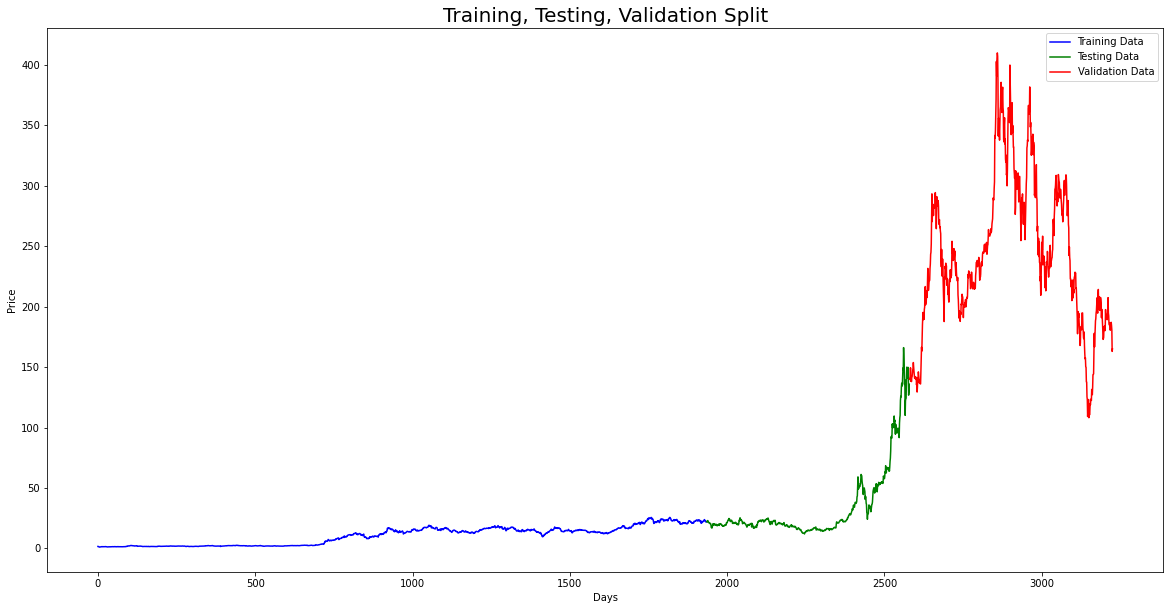

In [172]:
Training = range(len(y_train))
Test = range(len(y_train), len(y_train) + len(y_test))
Validation = range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val))

# Plot the data
plt.figure(figsize=(20,10))
plt.plot(df.index[Training], y_train, 'b-', label='Training Data')
plt.plot(df.index[Test], y_test, 'g-', label='Testing Data')
plt.plot(df.index[Validation], y_val, 'r-', label='Validation Data')


plt.title("Training, Testing, Validation Split", fontsize=20)
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()


In [188]:
# Normalizing the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_train_scaled = (y_train - scaler.mean_) / scaler.scale_
y_test_scaled = scaler.transform(y_test.values.reshape(-1,1))


# Calculate the mean and standard deviation for each feature
mu_test_list = scaler.mean_
std_test_list = scaler.scale_

In [189]:
#Code block taken from Yibin Ng at https://github.com/NGYB/Stocks/blob/master/StockPricePrediction/StockPricePrediction_v4_lstm.ipynb

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Training the Model

In [190]:
#Code block taken from Yibin Ng at https://github.com/NGYB/Stocks/blob/master/StockPricePrediction/StockPricePrediction_v4_lstm.ipynb

import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_test_scaled, \
                          y_test, \
                          mu_test_list, \
                          std_test_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))

    # Add dropput with a probability of 0.5
    model.add(Dropout(dropout_prob)) 
    model.add(LSTM(units=lstm_units))

    # Add dropput with a probability of 0.5
    model.add(Dropout(dropout_prob)) 
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs,batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(x_test_scaled)
    est = (est_scaled * std_test_list) + mu_test_list
    
    # Calculate RMSE and MAPE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return est, rmse, mape

In [191]:
train_pred_eval_model(X_train_scaled,y_train_scaled,X_test_scaled,y_test,mu_test_list,std_test_list)

#Note these predictions are wrong, need to figure out how to scale y_train using the same parameters as X_train

21/21 [==============================] - 0s 6ms/step


(array([[15.74714098],
        [15.6539966 ],
        [15.77436334],
        [16.34424353],
        [16.05705032],
        [16.2838135 ],
        [15.97785119],
        [15.8135045 ],
        [15.81399387],
        [15.40124722],
        [15.59137539],
        [15.43634824],
        [15.51466571],
        [15.60450269],
        [16.09526283],
        [15.98673143],
        [15.35457092],
        [15.37479011],
        [15.94625175],
        [16.02463424],
        [16.65674072],
        [16.27014368],
        [15.83888843],
        [15.93398897],
        [15.57242003],
        [15.5080645 ],
        [15.49996092],
        [15.24162642],
        [15.13249759],
        [15.2106477 ],
        [15.15883917],
        [15.12869597],
        [14.86301215],
        [14.8487159 ],
        [14.57992541],
        [14.58987884],
        [14.78590887],
        [14.94382391],
        [15.06557793],
        [15.76698898],
        [16.22288707],
        [15.36499482],
        [15.69597601],
        [15

In [192]:
# Apply Stochastic Gradient Descent to train
from sklearn.linear_model import SGDRegressor
regressor = SGDRegressor(loss = 'squared_error', learning_rate = 'constant',  alpha = 0.0001, eta0 = 0.01, max_iter=1000)
regressor.fit(X_train_scaled, y_train)
predictions = regressor.predict(X_test_scaled)
rmse = math.sqrt(mean_squared_error(y_test, predictions))
mape = get_mape(y_test, predictions)
print(predictions)
print('RMSE: ', rmse)
print('MAPE: ', mape)

[ 21.75235529  22.03987159  21.64326008  22.23090059  22.25696414
  22.16008322  21.8041624   21.50952213  20.99033556  20.86381478
  20.93781329  20.88828121  20.45748857  20.05969269  19.5159205
  17.24672122  17.11508681  16.76312921  17.53349801  17.47781648
  19.47756571  20.01220892  19.89135869  19.9075984   20.16852231
  19.93827478  20.02149745  19.67728576  19.14434577  19.51409127
  19.54653964  19.636216    19.19834849  18.86989189  18.78616087
  18.68664281  19.19127396  19.65914181  19.71355112  20.01116384
  18.55718066  19.04494887  19.91070176  20.13910363  20.14194728
  20.51591199  20.31532928  19.93098259  18.86845279  18.95726026
  19.07824185  18.67803374  18.92474741  18.78277174  18.44931149
  18.53129912  18.50312034  18.67134736  19.07068965  19.08938187
  19.1224157   19.68984955  19.55054505  20.28041961  21.20124531
  21.28433356  21.65948588  22.82712029  22.8758386   23.30632607
  23.67661088  23.98020862  23.87798949  23.7975059   23.78398841
  22.890395